# Loss Function
#### Regression problem: Mean Squard Error or Mean Absoluate Error
#### Binary classification problem: Binary Cross-Entropy
#### Multiclass classification problem: Categorical Cross-Entropy

##### MSE: (Σ( y - y' )^2)/N
##### MAE: (Σ| y - y' |)/N
預測結果在-1~1之間，MAE損失較大。如果大於1或小於-1，MSE損失較大。

# Gradient Descent
#### 尋找合適的Weight和Bias使Loss值越來越小。
##### W = W - η(∂L/∂W)
##### L: Loss function
##### W: Weight
##### η: Learning rate
此方法不一定能找到全域最小值(Global minimum)，有可只是區域最小值(Local minimum)。  
GD是一次使用全部訓練資料計算LF的梯度再更新一次W。如果要更新N次，就要重新訓練N遍。  
- - - - - - - - - - - -  - - - - - -  - - - - - -
隨機梯度下降法(SGD, Stochastic Gradient Descent)：  
一次計算一個批次(Batch)資料的梯度值並更新一次W。  
- - - - - - - - - - - -  - - - - - -  - - - - - -
除了SGD外，還有Momentum、AdaGrad、Adam等方法。  
Momentum：加入運動量的概念。把LF當作山坡，會有上下坡的狀況。  
AdaGrad：根據梯度來調整LR。  
Adam：結合Momentum和AdaGrad。　　

# Learning Rate
#### 學習率決定演算法優化的步伐，過大可能錯過最小值(minimum)並產生震盪；過小可能學習效率低。

# 訓練步驟
##### 1. Training data分為訓練資料(Input X)和預期輸出的標記答案(Input Y)。
##### 2. 建立Model，預測(Prediction)數值 y' 。
##### 3. LF計算 y' 和標記答案(Input Y)的 y 間的誤差。
##### 4. 優化器(Optimizer)決定訓練過程如何進行，如SGD、Adam、RMSprop等。
##### 5. 準備驗證資料(Validation data)和測試資料(Test data)，讓Model預測，並透過指標函數(Metrics Function, 評估函數)來評估模型好壞。

# 實驗一：房價預測模型

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# 讀資料
data = pd.read_csv("./Datasets/Ch2/kc_house_data.csv")
data.shape

(21613, 21)

In [3]:
# 顯示資料
pd.options.display.max_columns = 25 # 設定列數
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# 檢查型別
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
# 將 "data" 轉換為數值格式。拆為年月日。
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))
# 刪除後段沒用的資料，inplace是將更新後的資料放回原本的地方。
data.drop(['id'], axis="columns", inplace=True) # 此段會將 id 刪除。
data.drop(['date'], axis="columns", inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [6]:
# 分為Train、Valid、Test
data_num = data.shape[0]
indexes = np.random.permutation(data_num)
print("總筆數: {}".format(data_num))
print("indexes: {}".format(indexes)) # 用於取得一筆與 data 數量相同的亂數索引，目的是用來打散資料。
# Train：Valid：Test = 6：2：2
train_indexes = indexes[:int(data_num * 0.6)]
valid_indexes = indexes[int(data_num * 0.6):int(data_num * 0.8)]
test_indexes = indexes[int(data_num * 0.8):]
# 取出資料
train_data = data.loc[train_indexes]
valid_data = data.loc[valid_indexes]
test_data = data.loc[test_indexes]

總筆數: 21613
indexes: [ 4587  7569  7015 ... 21446   848  1084]


# 標準化(Normalization, 或稱正規化)
#### 主要功用是將不同的資料縮放到相同的大小。
##### ex. 臥室數量在1-5，坪數在1500-2500m^2，兩者資料量級差距甚大，導致網路只重視較大的資料而忽略小資料。
##### 以下使用標準分數(Standard Score, 又稱z-score)。經過z-score的資料都會聚集在0附近且標準差為1。
##### X(norm) = ( x - mean ) / std

In [7]:
train_valid_data = pd.concat([train_data, valid_data])
mean = train_valid_data.mean()
std = train_valid_data.std()
train_data = (train_data - mean) / std
valid_data = (valid_data - mean) / std

In [8]:
# 建立Numpy Array格式的訓練資料
x_train = np.array(train_data.drop('price', axis='columns')) # 拿掉price，其餘皆為輸入資料
y_train = np.array(train_data['price']) # 只包含price，作為標籤資料
x_val = np.array(valid_data.drop('price', axis='columns'))
y_val = np.array(valid_data['price'])

In [9]:
x_train.shape

(12967, 21)

In [10]:
# 建立模型
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(21,)), # 實際上輸入的形狀為(batch_size, 21)
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # 由於需要線性輸出，故不加 activation
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 設定Optimizer、Loss Function、Metrics Function
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()]
             )

In [12]:
model_dir = './models/Ch2/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [13]:
# TensorBoard 回調函數會幫忙紀錄訓練資料，並儲存成 TensorBoard 的記錄檔
log_dir = os.path.join('./models/Ch2', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint 回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，
#「monitor」表示被監測的資料，「mode」min代表監測資料越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min'
                                            )

In [14]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    callbacks=[model_cbk, model_mckp]
                   )

Epoch 1/300
 1/51 [..............................] - ETA: 0s - loss: 1.0155 - mean_absolute_error: 0.6546WARNING:tensorflow:From C:\Users\a7032\AI_Deep_Learing\Tensorflow2\tf2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
51/51 [==============================] - 0s 4ms/step - loss: 0.4402 - mean_absolute_error: 0.4062 - val_loss: 0.2546 - val_mean_absolute_error: 0.3239
Epoch 2/300
51/51 [==============================] - 0s 2ms/step - loss: 0.2602 - mean_absolute_error: 0.3141 - val_loss: 0.2080 - val_mean_absolute_error: 0.2987
Epoch 3/300
51/51 [==============================] - 0s 2ms/step - loss: 0.2259 - mean_absolute_error: 0.2954 - val_loss: 0.1884 - val_mean_absolute_error: 0.2803
Epoch 4/300
51/51 [==============================] - 0s 2ms/step - loss: 0.2033 - mean_absolute_error: 0.2775 - va

51/51 [==============================] - 0s 2ms/step - loss: 0.0490 - mean_absolute_error: 0.1545 - val_loss: 0.1121 - val_mean_absolute_error: 0.2028
Epoch 98/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0489 - mean_absolute_error: 0.1554 - val_loss: 0.1136 - val_mean_absolute_error: 0.2031
Epoch 99/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0493 - mean_absolute_error: 0.1558 - val_loss: 0.1160 - val_mean_absolute_error: 0.2046
Epoch 100/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0499 - mean_absolute_error: 0.1560 - val_loss: 0.1109 - val_mean_absolute_error: 0.2024
Epoch 101/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0509 - mean_absolute_error: 0.1581 - val_loss: 0.1152 - val_mean_absolute_error: 0.2052
Epoch 102/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0492 - mean_absolute_error: 0.1553 - val_loss: 0.1166 - val_mean_absolute_error: 0.2064
Epoch 103/300
51/51 [=====

Epoch 196/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0361 - mean_absolute_error: 0.1392 - val_loss: 0.1197 - val_mean_absolute_error: 0.2073
Epoch 197/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0353 - mean_absolute_error: 0.1369 - val_loss: 0.1189 - val_mean_absolute_error: 0.2090
Epoch 198/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0352 - mean_absolute_error: 0.1370 - val_loss: 0.1184 - val_mean_absolute_error: 0.2074
Epoch 199/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0362 - mean_absolute_error: 0.1385 - val_loss: 0.1209 - val_mean_absolute_error: 0.2103
Epoch 200/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0358 - mean_absolute_error: 0.1372 - val_loss: 0.1251 - val_mean_absolute_error: 0.2136
Epoch 201/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0359 - mean_absolute_error: 0.1375 - val_loss: 0.1230 - val_mean_absolute_error: 0.2105
Epoch 202/

Epoch 295/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.1305 - val_loss: 0.1305 - val_mean_absolute_error: 0.2184
Epoch 296/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.1307 - val_loss: 0.1273 - val_mean_absolute_error: 0.2129
Epoch 297/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_absolute_error: 0.1276 - val_loss: 0.1301 - val_mean_absolute_error: 0.2130
Epoch 298/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_absolute_error: 0.1275 - val_loss: 0.1319 - val_mean_absolute_error: 0.2192
Epoch 299/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0292 - mean_absolute_error: 0.1273 - val_loss: 0.1304 - val_mean_absolute_error: 0.2151
Epoch 300/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0292 - mean_absolute_error: 0.1278 - val_loss: 0.1263 - val_mean_absolute_error: 0.2152


In [15]:
history.history.keys() # 查看儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

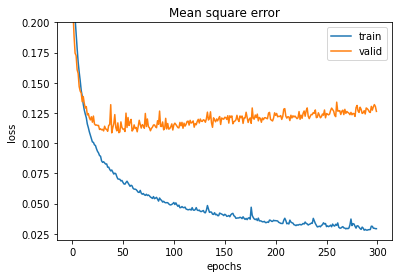

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Mean square error')
plt.ylim(0.02, 0.2)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

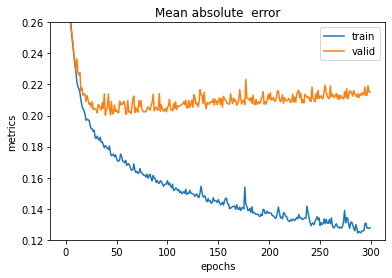

In [17]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.title('Mean absolute  error')
plt.ylim(0.12, 0.26)
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.legend(loc='upper right')

In [18]:
model = keras.models.load_model('./models/Ch2/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化
test_data = (test_data - mean) / std
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測
y_pred = model.predict(x_test)
# 將預測結果轉換回來，因為訓練時的訓練目標也有經過標準化
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比 MAE
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 13.56%


# TensorBoard 介紹
#### Method_1：Jupyter notebook
```
%load_ext tensorboard
%tensorboard --logdir yourPath
```
#### Method_2：CMD
```
tensorboard --logdir yourPath
or
tensorboard --port 9487 --logdir yourPath
```

In [19]:
%load_ext tensorboard
%tensorboard --logdir models/Ch2

Reusing TensorBoard on port 6006 (pid 15792), started 0:26:34 ago. (Use '!kill 15792' to kill it.)

# 實驗二：過擬合問題
#### 過擬合(Overfitting)指訓練的網路模型對驗證資料集的效果很差，卻對訓練資料集效果很好。
#### ex. Train_loss持續下降，但Valid_loss卻上升。
#### 原因可能是在於模型過於複雜及訓練資料太少。

# 方法一：縮減模型大小

In [20]:
# 建立模型
model_2 = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(21,)), # 實際上輸入的形狀為(batch_size, 21)
    layers.Dense(16, activation='relu'),
    layers.Dense(1) # 由於需要線性輸出，故不加 activation
])
model_2.summary()
# 設定Optimizer、Loss Function、Metrics Function
model_2.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()]
             ) 
# 設定回調函數
log_dir = os.path.join('./models/Ch2', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min'
                                            )
history = model_2.fit(x_train, y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    callbacks=[model_cbk, model_mckp]
                   )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                352       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
51/51 [==============================] - 0s 4ms/step - loss: 1.0253 - mean_absolute_error: 0.6799 - val_loss: 0.5424 - val_mean_absolute_error: 0.5226
Epoch 2/300
51/51 [==============================] - 0s 2ms/step - loss: 0.5509 - mean_absolute_error: 0.4770 - val_loss: 0.3746 - val_mean_absolute_error: 0.4208
Epoch 3/300
51/51 [==============================] - 0s 3ms/

Epoch 45/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1258 - mean_absolute_error: 0.2212 - val_loss: 0.1331 - val_mean_absolute_error: 0.2270
Epoch 46/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1234 - mean_absolute_error: 0.2193 - val_loss: 0.1316 - val_mean_absolute_error: 0.2262
Epoch 47/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1228 - mean_absolute_error: 0.2191 - val_loss: 0.1322 - val_mean_absolute_error: 0.2253
Epoch 48/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1218 - mean_absolute_error: 0.2179 - val_loss: 0.1317 - val_mean_absolute_error: 0.2246
Epoch 49/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1200 - mean_absolute_error: 0.2166 - val_loss: 0.1301 - val_mean_absolute_error: 0.2249
Epoch 50/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1187 - mean_absolute_error: 0.2159 - val_loss: 0.1336 - val_mean_absolute_error: 0.2249
Epoch 51/300
51/

Epoch 95/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0971 - mean_absolute_error: 0.1961 - val_loss: 0.1242 - val_mean_absolute_error: 0.2134
Epoch 96/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0970 - mean_absolute_error: 0.1967 - val_loss: 0.1247 - val_mean_absolute_error: 0.2138
Epoch 97/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0965 - mean_absolute_error: 0.1960 - val_loss: 0.1200 - val_mean_absolute_error: 0.2101
Epoch 98/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0971 - mean_absolute_error: 0.1958 - val_loss: 0.1237 - val_mean_absolute_error: 0.2141
Epoch 99/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0965 - mean_absolute_error: 0.1959 - val_loss: 0.1226 - val_mean_absolute_error: 0.2109
Epoch 100/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0955 - mean_absolute_error: 0.1945 - val_loss: 0.1204 - val_mean_absolute_error: 0.2095
Epoch 101/300
5

Epoch 145/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0890 - mean_absolute_error: 0.1891 - val_loss: 0.1217 - val_mean_absolute_error: 0.2073
Epoch 146/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0888 - mean_absolute_error: 0.1881 - val_loss: 0.1181 - val_mean_absolute_error: 0.2051
Epoch 147/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0884 - mean_absolute_error: 0.1875 - val_loss: 0.1124 - val_mean_absolute_error: 0.2022
Epoch 148/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0892 - mean_absolute_error: 0.1889 - val_loss: 0.1143 - val_mean_absolute_error: 0.2034
Epoch 149/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0877 - mean_absolute_error: 0.1870 - val_loss: 0.1180 - val_mean_absolute_error: 0.2052
Epoch 150/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0883 - mean_absolute_error: 0.1883 - val_loss: 0.1175 - val_mean_absolute_error: 0.2034
Epoch 151/

Epoch 195/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0852 - mean_absolute_error: 0.1856 - val_loss: 0.1239 - val_mean_absolute_error: 0.2075
Epoch 196/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0853 - mean_absolute_error: 0.1867 - val_loss: 0.1168 - val_mean_absolute_error: 0.2018
Epoch 197/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0846 - mean_absolute_error: 0.1850 - val_loss: 0.1157 - val_mean_absolute_error: 0.2019
Epoch 198/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0840 - mean_absolute_error: 0.1840 - val_loss: 0.1177 - val_mean_absolute_error: 0.2023
Epoch 199/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0835 - mean_absolute_error: 0.1833 - val_loss: 0.1208 - val_mean_absolute_error: 0.2035
Epoch 200/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0844 - mean_absolute_error: 0.1841 - val_loss: 0.1167 - val_mean_absolute_error: 0.2034
Epoch 201/

Epoch 245/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0802 - mean_absolute_error: 0.1810 - val_loss: 0.1127 - val_mean_absolute_error: 0.1998
Epoch 246/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0811 - mean_absolute_error: 0.1808 - val_loss: 0.1103 - val_mean_absolute_error: 0.1990
Epoch 247/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0818 - mean_absolute_error: 0.1818 - val_loss: 0.1152 - val_mean_absolute_error: 0.2023
Epoch 248/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0803 - mean_absolute_error: 0.1811 - val_loss: 0.1176 - val_mean_absolute_error: 0.2026
Epoch 249/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0802 - mean_absolute_error: 0.1807 - val_loss: 0.1140 - val_mean_absolute_error: 0.2009
Epoch 250/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0797 - mean_absolute_error: 0.1806 - val_loss: 0.1168 - val_mean_absolute_error: 0.2016
Epoch 251/

Epoch 295/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0787 - mean_absolute_error: 0.1798 - val_loss: 0.1136 - val_mean_absolute_error: 0.2003
Epoch 296/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0783 - mean_absolute_error: 0.1804 - val_loss: 0.1120 - val_mean_absolute_error: 0.1996
Epoch 297/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0786 - mean_absolute_error: 0.1791 - val_loss: 0.1148 - val_mean_absolute_error: 0.2016
Epoch 298/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0782 - mean_absolute_error: 0.1794 - val_loss: 0.1195 - val_mean_absolute_error: 0.2026
Epoch 299/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0789 - mean_absolute_error: 0.1797 - val_loss: 0.1118 - val_mean_absolute_error: 0.1992
Epoch 300/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0782 - mean_absolute_error: 0.1796 - val_loss: 0.1151 - val_mean_absolute_error: 0.2016


In [21]:
model = keras.models.load_model('./models/Ch2/Best-model-2.h5')
# 預測
y_pred = model.predict(x_test)
# 將預測結果轉換回來，因為訓練時的訓練目標也有經過標準化
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比 MAE
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_2 Percentage Error: {:.2f}%".format(percentage_error))

Model_2 Percentage Error: 13.35%


# 方法二：加入權重正規化(Weights Regularization)
#### 有兩種方法，L1 regularization 和 L2 regularization(又稱為weight decay)。
#### 其核心思想都是透過限制權重大小解決過擬合的問題。
#### ex. 模型若想擬合所有訓練資料，就必須仰賴越複雜的參數，而權重正規化則是抵制模型太過於依賴特定的參數。
##### L1：Loss(total) = Loss(MSE) + λΣ| wj |    ( j = 0 ~ M )
##### L2：Loss(total) = Loss(MSE) + λΣ( wj )^2    ( j = 0 ~ M )
##### λ：為可調整參數，用來控制權重正規化的強度。
##### w：模型權重。
##### M：模型總參數量。
##### Loss(MSE)：Mean Squared Error 的 Loss 值。
##### Loss(total)：Loss 值加上權重正規化。

In [24]:
# 建立模型
# 使用 L2 正規化。在每一層隱藏層加入L2，且使用 λ=0.001的正規化強度。
model_3 = tf.keras.Sequential([
    layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(21,)), # 實際上輸入的形狀為(batch_size, 21)
    layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
    layers.Dense(1) # 由於需要線性輸出，故不加 activation
])
model_3.summary()
# 設定Optimizer、Loss Function、Metrics Function
model_3.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()]
             ) 
# 設定回調函數
log_dir = os.path.join('./models/Ch2', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min'
                                            )
history = model_3.fit(x_train, y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    callbacks=[model_cbk, model_mckp]
                   )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
51/51 [==============================] - 0s 4ms/step - loss: 0.6193 - mean_absolute_error: 0.4478 - val_loss: 0.3733 - val_mean_absolute_error: 0.3486
Epoch 2/300
51/51 [==============================] - 0s 2ms/step - loss: 0.3624 - mean_absolute_error: 0.3234 - val_loss: 0.3097 - val_mean_absolute_error: 0.3029
Epoch 3/300
51/51 [==============================] - 0s 

Epoch 45/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1301 - mean_absolute_error: 0.1867 - val_loss: 0.1562 - val_mean_absolute_error: 0.2042
Epoch 46/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1276 - mean_absolute_error: 0.1845 - val_loss: 0.1584 - val_mean_absolute_error: 0.2022
Epoch 47/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1274 - mean_absolute_error: 0.1833 - val_loss: 0.1596 - val_mean_absolute_error: 0.2049
Epoch 48/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1268 - mean_absolute_error: 0.1845 - val_loss: 0.1522 - val_mean_absolute_error: 0.2010
Epoch 49/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1254 - mean_absolute_error: 0.1841 - val_loss: 0.1546 - val_mean_absolute_error: 0.2003
Epoch 50/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1235 - mean_absolute_error: 0.1808 - val_loss: 0.1505 - val_mean_absolute_error: 0.2018
Epoch 51/300
51/

Epoch 95/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0992 - mean_absolute_error: 0.1716 - val_loss: 0.1441 - val_mean_absolute_error: 0.1966
Epoch 96/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0977 - mean_absolute_error: 0.1700 - val_loss: 0.1396 - val_mean_absolute_error: 0.2007
Epoch 97/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0958 - mean_absolute_error: 0.1680 - val_loss: 0.1371 - val_mean_absolute_error: 0.1919
Epoch 98/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0949 - mean_absolute_error: 0.1669 - val_loss: 0.1368 - val_mean_absolute_error: 0.1953
Epoch 99/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0950 - mean_absolute_error: 0.1676 - val_loss: 0.1336 - val_mean_absolute_error: 0.1901
Epoch 100/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0993 - mean_absolute_error: 0.1723 - val_loss: 0.1337 - val_mean_absolute_error: 0.1917
Epoch 101/300
5

Epoch 145/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0834 - mean_absolute_error: 0.1638 - val_loss: 0.1468 - val_mean_absolute_error: 0.2002
Epoch 146/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0851 - mean_absolute_error: 0.1648 - val_loss: 0.1306 - val_mean_absolute_error: 0.1917
Epoch 147/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0837 - mean_absolute_error: 0.1626 - val_loss: 0.1406 - val_mean_absolute_error: 0.1972
Epoch 148/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0837 - mean_absolute_error: 0.1639 - val_loss: 0.1266 - val_mean_absolute_error: 0.1870
Epoch 149/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0841 - mean_absolute_error: 0.1649 - val_loss: 0.1286 - val_mean_absolute_error: 0.1897
Epoch 150/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0806 - mean_absolute_error: 0.1596 - val_loss: 0.1314 - val_mean_absolute_error: 0.1966
Epoch 151/

Epoch 195/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0758 - mean_absolute_error: 0.1571 - val_loss: 0.1219 - val_mean_absolute_error: 0.1897
Epoch 196/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0746 - mean_absolute_error: 0.1563 - val_loss: 0.1301 - val_mean_absolute_error: 0.1986
Epoch 197/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0743 - mean_absolute_error: 0.1554 - val_loss: 0.1263 - val_mean_absolute_error: 0.1886
Epoch 198/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0727 - mean_absolute_error: 0.1536 - val_loss: 0.1251 - val_mean_absolute_error: 0.1876
Epoch 199/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0731 - mean_absolute_error: 0.1545 - val_loss: 0.1228 - val_mean_absolute_error: 0.1868
Epoch 200/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0749 - mean_absolute_error: 0.1571 - val_loss: 0.1258 - val_mean_absolute_error: 0.1908
Epoch 201/

Epoch 245/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0686 - mean_absolute_error: 0.1516 - val_loss: 0.1233 - val_mean_absolute_error: 0.1877
Epoch 246/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0686 - mean_absolute_error: 0.1510 - val_loss: 0.1266 - val_mean_absolute_error: 0.1901
Epoch 247/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0711 - mean_absolute_error: 0.1533 - val_loss: 0.1220 - val_mean_absolute_error: 0.1870
Epoch 248/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0698 - mean_absolute_error: 0.1530 - val_loss: 0.1308 - val_mean_absolute_error: 0.1952
Epoch 249/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0690 - mean_absolute_error: 0.1520 - val_loss: 0.1256 - val_mean_absolute_error: 0.1908
Epoch 250/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0703 - mean_absolute_error: 0.1546 - val_loss: 0.1252 - val_mean_absolute_error: 0.1885
Epoch 251/

Epoch 295/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0642 - mean_absolute_error: 0.1479 - val_loss: 0.1235 - val_mean_absolute_error: 0.1876
Epoch 296/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0664 - mean_absolute_error: 0.1495 - val_loss: 0.1358 - val_mean_absolute_error: 0.1957
Epoch 297/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0682 - mean_absolute_error: 0.1524 - val_loss: 0.1270 - val_mean_absolute_error: 0.1931
Epoch 298/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0677 - mean_absolute_error: 0.1546 - val_loss: 0.1352 - val_mean_absolute_error: 0.2018
Epoch 299/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0679 - mean_absolute_error: 0.1526 - val_loss: 0.1364 - val_mean_absolute_error: 0.2060
Epoch 300/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0678 - mean_absolute_error: 0.1531 - val_loss: 0.1253 - val_mean_absolute_error: 0.1958


In [25]:
model = keras.models.load_model('./models/Ch2/Best-model-3.h5')
# 預測
y_pred = model.predict(x_test)
# 將預測結果轉換回來，因為訓練時的訓練目標也有經過標準化
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比 MAE
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_3 Percentage Error: {:.2f}%".format(percentage_error))

Model_3 Percentage Error: 12.81%


# 方法三：加入Dropout
#### Dropout意思是指捨棄模型參數，捨棄的比例自行決定。
#### Dropout只在訓練時啟動，測試時則關閉。
#### 旨在讓NN在每次訓練都使用不同的神經元學習，此舉可避免NN過度仰賴局部的特徵。

In [26]:
# 建立模型
# 在通過每層NN後，捨棄30%。
model_4 = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(21,)), # 實際上輸入的形狀為(batch_size, 21)
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1) # 由於需要線性輸出，故不加 activation
])
model_4.summary()
# 設定Optimizer、Loss Function、Metrics Function
model_4.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()]
             ) 
# 設定回調函數
log_dir = os.path.join('./models/Ch2', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min'
                                            )
history = model_4.fit(x_train, y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    callbacks=[model_cbk, model_mckp]
                   )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1408      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
51/51 [==============================] - 0s 4ms/step - loss: 0.7158 - mean_absolute_error: 0.5792 - val_lo

51/51 [==============================] - 0s 2ms/step - loss: 0.1342 - mean_absolute_error: 0.2315 - val_loss: 0.1167 - val_mean_absolute_error: 0.2150
Epoch 94/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1362 - mean_absolute_error: 0.2321 - val_loss: 0.1286 - val_mean_absolute_error: 0.2126
Epoch 95/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1388 - mean_absolute_error: 0.2337 - val_loss: 0.1126 - val_mean_absolute_error: 0.2114
Epoch 96/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1292 - mean_absolute_error: 0.2317 - val_loss: 0.1133 - val_mean_absolute_error: 0.2085
Epoch 97/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1274 - mean_absolute_error: 0.2287 - val_loss: 0.1109 - val_mean_absolute_error: 0.2032
Epoch 98/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1351 - mean_absolute_error: 0.2314 - val_loss: 0.1089 - val_mean_absolute_error: 0.2024
Epoch 99/300
51/51 [=========

Epoch 143/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1262 - mean_absolute_error: 0.2227 - val_loss: 0.1144 - val_mean_absolute_error: 0.2081
Epoch 144/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1234 - mean_absolute_error: 0.2228 - val_loss: 0.1078 - val_mean_absolute_error: 0.2027
Epoch 145/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1180 - mean_absolute_error: 0.2221 - val_loss: 0.1096 - val_mean_absolute_error: 0.2130
Epoch 146/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1299 - mean_absolute_error: 0.2243 - val_loss: 0.1129 - val_mean_absolute_error: 0.2167
Epoch 147/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1239 - mean_absolute_error: 0.2231 - val_loss: 0.1068 - val_mean_absolute_error: 0.2041
Epoch 148/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1211 - mean_absolute_error: 0.2216 - val_loss: 0.1074 - val_mean_absolute_error: 0.2051
Epoch 149/

Epoch 193/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1180 - mean_absolute_error: 0.2178 - val_loss: 0.1109 - val_mean_absolute_error: 0.2059
Epoch 194/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1159 - mean_absolute_error: 0.2188 - val_loss: 0.1093 - val_mean_absolute_error: 0.2089
Epoch 195/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.2173 - val_loss: 0.1064 - val_mean_absolute_error: 0.2021
Epoch 196/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1260 - mean_absolute_error: 0.2183 - val_loss: 0.1072 - val_mean_absolute_error: 0.2060
Epoch 197/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1175 - mean_absolute_error: 0.2161 - val_loss: 0.1087 - val_mean_absolute_error: 0.2085
Epoch 198/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1138 - mean_absolute_error: 0.2157 - val_loss: 0.1058 - val_mean_absolute_error: 0.2006
Epoch 199/

Epoch 243/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1083 - mean_absolute_error: 0.2118 - val_loss: 0.1098 - val_mean_absolute_error: 0.2045
Epoch 244/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1138 - mean_absolute_error: 0.2144 - val_loss: 0.1096 - val_mean_absolute_error: 0.2034
Epoch 245/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1091 - mean_absolute_error: 0.2122 - val_loss: 0.1102 - val_mean_absolute_error: 0.2045
Epoch 246/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1109 - mean_absolute_error: 0.2154 - val_loss: 0.1132 - val_mean_absolute_error: 0.2118
Epoch 247/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1108 - mean_absolute_error: 0.2145 - val_loss: 0.1081 - val_mean_absolute_error: 0.1972
Epoch 248/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1074 - mean_absolute_error: 0.2130 - val_loss: 0.1094 - val_mean_absolute_error: 0.2013
Epoch 249/

In [27]:
model = keras.models.load_model('./models/Ch2/Best-model-4.h5')
# 預測
y_pred = model.predict(x_test)
# 將預測結果轉換回來，因為訓練時的訓練目標也有經過標準化
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比 MAE
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_3 Percentage Error: {:.2f}%".format(percentage_error))

Model_3 Percentage Error: 13.43%


# TensorBoard分析上述的方法

In [28]:
%load_ext tensorboard
%tensorboard --logdir models/Ch2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15792), started 1:29:22 ago. (Use '!kill 15792' to kill it.)